In [41]:
import os
import json
from neo4j import GraphDatabase
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import glob
from matplotlib.colors import ListedColormap

In [42]:
uri = "neo4j://localhost:7687"
userName = "neo4j"
password = "password"

In [43]:
# Connect to the neo4j database server
graph_db_driver  = GraphDatabase.driver(uri, auth=(userName, password))

In [44]:
base_dir = '/Users/janamian/Documents/workstation/ucsd_dse_program/fall_2019/docker_vol/saba-ja/workstation/dse_203_2020/project/dse_203_final_project_fall_2020/data'

In [45]:
nvdcve_files = sorted(glob.glob(os.path.join(base_dir, 'nvd_data','nvdcve-1.1*.json')), reverse=True)

In [46]:
for val in nvdcve_files:
    print(val.split('/')[-1])

nvdcve-1.1-2020.json
nvdcve-1.1-2019.json
nvdcve-1.1-2018.json
nvdcve-1.1-2017.json
nvdcve-1.1-2016.json
nvdcve-1.1-2015.json
nvdcve-1.1-2014.json
nvdcve-1.1-2013.json
nvdcve-1.1-2012.json
nvdcve-1.1-2011.json
nvdcve-1.1-2010.json
nvdcve-1.1-2009.json
nvdcve-1.1-2008.json
nvdcve-1.1-2007.json
nvdcve-1.1-2006.json
nvdcve-1.1-2005.json
nvdcve-1.1-2004.json
nvdcve-1.1-2003.json
nvdcve-1.1-2002.json


In [47]:
with open(os.path.join(base_dir, 'cwe_data', 'cwec_v4.2.json')) as f:
    cwe = json.load(f)
nvd_list = []
for file_addr in nvdcve_files:
    with open(file_addr) as f:
        nvd_list.append(json.load(f))
#     break

In [48]:
print('Number of reported CVEs in each year')
total_cve = 0
for val in nvd_list:
    total_cve += len(val['CVE_Items'])
    print(len(val['CVE_Items']))
    
print(total_cve)

Number of reported CVEs in each year
12963
16154
16482
16394
10338
8518
8845
6629
5823
4813
5173
5001
7160
6572
7135
4761
2707
1550
6767
153785


In [49]:
# Count types
cwe_type_counter = {}
for obj in cwe['Weakness_Catalog']['Weaknesses']['Weakness']:
    for key, val in obj.items():
        t = cwe_type_counter.get(key, 0)
        if t == 0:
            cwe_type_counter[key] = 1
        else:
            cwe_type_counter[key] = cwe_type_counter[key] + 1

In [50]:
def get_related_cwe(data_list):
    # CVE object
    resultw = []
    if not isinstance(data_list['problemtype']['problemtype_data'], list):
        print(data_list['problemtype']['problemtype_data'])
        raise ValueError
        
    if len(data_list['problemtype']['problemtype_data']) != 1:
        print(data_list['problemtype']['problemtype_data'])
        raise ValueError
        
    for val in data_list['problemtype']['problemtype_data'][0]['description']:
        resultw.append(val['value'])
    return resultw

def get_reference_url(data_list):
    result = []
    for val in data_list['references']['reference_data']:
        result.append(val['url'])
    return result

def get_tags(data_list):
    result = []
    for val in data_list['references']['reference_data']:
        for val2 in val['tags']:
            result.append(val2)

    return result

def get_description_data(data_list):
    result = []
    for val in data_list['description']['description_data']:
        if val['lang'] == 'en':
            result.append(val['value'])
    return result

def get_cpe_match(cpe_match_list):
    result = []
    try:
        for val in cpe_match_list['cpe_match']:
            result.append(val['cpe23Uri'])
    except KeyError:
        pass
    return result

def get_impacted_configuration(data_list):
    result = []
    for val in data_list['nodes']:

        result.extend(get_cpe_match(val))
        
        if 'children' in val.keys():
            for val2 in val['children']:
                result.extend(get_cpe_match(val2))

    return result

cve_clean_result = []
total_cwes = 0
for nvd_obj in nvd_list:
    for cve_obj in nvd_obj['CVE_Items']:
        cve_id = cve_obj['cve']['CVE_data_meta']['ID']
        related_cwe_list = get_related_cwe(cve_obj['cve'])
        total_cwes += len(related_cwe_list)
        description = get_description_data(cve_obj['cve'])
#         if len(related_cwe_list) == 0:
#             print(cve_id, ' has 0 cwes', description)
        
        reference_url = get_reference_url(cve_obj['cve'])
        tags = get_tags(cve_obj['cve'])
        
        try:
            cvss_base_score = cve_obj['impact']['baseMetricV3']['cvssV3']['baseScore']
            cvss_base_severity = cve_obj['impact']['baseMetricV3']['cvssV3']['baseSeverity']
        except KeyError:
            cvss_base_score = 'unknown'
            cvss_base_severity = 'unknown'

        impacted_config = get_impacted_configuration(cve_obj['configurations'])
        
        published_date = cve_obj['publishedDate']
        modified_date = cve_obj['lastModifiedDate']
        
        cve_clean_result.append({
            'cve_id': cve_id,
            'related_cwe_list':related_cwe_list,
            'description': description,
            'reference_url':reference_url,
            'tags':tags,
            'cvss_base_score': cvss_base_score,
            'cvss_base_severity':cvss_base_severity,
            'impacted_config': impacted_config,
            'published_date': published_date,
            'modified_date': modified_date
         })

In [51]:
print(len(cve_clean_result), total_cwes)

153785 147139


In [52]:
# #############
# Count CWEs causing CVE
# #############

cwe_count = {}
for val in cve_clean_result:
    for cwe in val['related_cwe_list']:
        cwe_c = cwe_count.get(cwe, 0)
        cwe_c += 1
        cwe_count[cwe] = cwe_c

In [53]:
data = {'cwe_id':[], 'count':[]}
for key, value in cwe_count.items():
    data['cwe_id'].append(f'{key}')
    data['count'].append(value)
    
cwe_count_df = pd.DataFrame(data)
cwe_count_df.sort_values(by=['count'], ascending=False, inplace=True)
cwe_count_df.reset_index(drop=True, inplace=True)
cwe_count_filtered_gt_n = cwe_count_df[cwe_count_df['count'] >= 250]

In [54]:
153785 - cwe_count_df['count'].sum()

6646

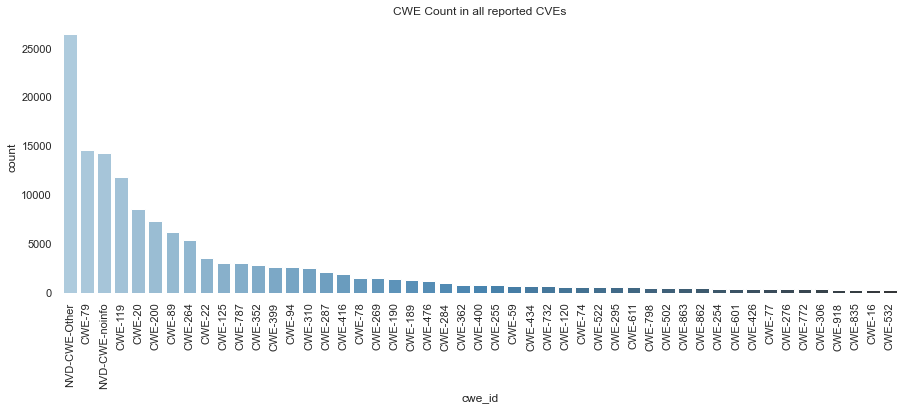

In [55]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="cwe_id", y="count", palette="Blues_d", data=cwe_count_filtered_gt_n, ci=None);
plt.title('CWE Count in all reported CVEs')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

In [56]:
less_than_n_cwe = cwe_count_df[cwe_count_df['count'] < 5000]['count'].sum()

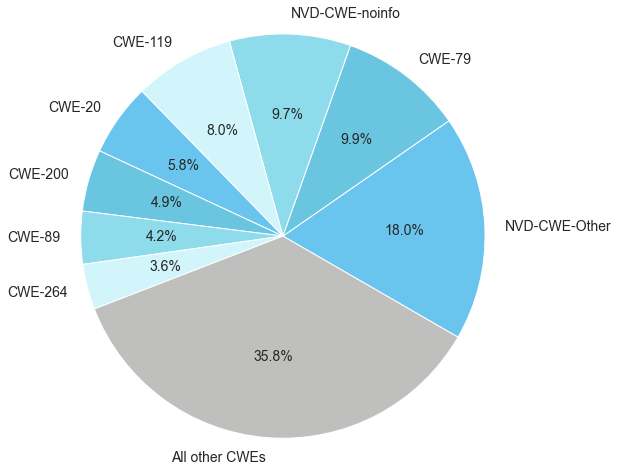

In [57]:
labels = list(cwe_count_df[cwe_count_df['count'] >= 5000]['cwe_id'])
labels.append('All other CWEs')
sizes = list(cwe_count_df[cwe_count_df['count'] >= 5000]['count'])
sizes.append(less_than_n_cwe)
# explode = (0,0,0,0,0,0,0,0.0, 0.1)
pie_chart_color_list=["#53AAC0", "#53AACC", "#69C5E0", "#8DDBEB", "#D1F5FA"]
pie_chart_color_list=["#69C5EE", "#69C5E0", "#8DDBEB", "#D1F5FA","#69C5EE", "#69C5E0", "#8DDBEB", "#D1F5FA", '#BFBFBD']
# pie_chart_color_list=["#53AACC",'#ffcc99' ,'#66b3ff','#99ff99','#ff9999']
# explode=explode,
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes,  
        labels=labels, 
        autopct='%1.1f%%',
        shadow=False, 
        startangle=-30, 
        colors=pie_chart_color_list, 
        textprops={'fontsize': 14})

ax1.axis('equal')

plt.show()

In [58]:
sum(sizes)

147139

In [59]:
labels

['NVD-CWE-Other',
 'CWE-79',
 'NVD-CWE-noinfo',
 'CWE-119',
 'CWE-20',
 'CWE-200',
 'CWE-89',
 'CWE-264',
 'All other CWEs']

In [60]:
column_names = []
column_names.extend(labels)
cve_to_cwe_per_year_df = pd.DataFrame(columns=column_names, index=list(range(1988,2021)))
cve_to_cwe_per_year_df.fillna(0, inplace=True)

In [61]:
for val in cve_clean_result:
    year_val = int(val['published_date'].split('-')[0])
    for cwe in val['related_cwe_list']:
        if cwe in column_names:
            cwe_count = cve_to_cwe_per_year_df.loc[year_val, cwe]
            cve_to_cwe_per_year_df.loc[year_val, cwe] = cwe_count + 1
        else:
            cwe_count = cve_to_cwe_per_year_df.loc[year_val, 'All other CWEs']
            cve_to_cwe_per_year_df.loc[year_val, 'All other CWEs'] = cwe_count + 1

In [62]:
cve_to_cwe_per_year_df

,NVD-CWE-Other,CWE-79,NVD-CWE-noinfo,CWE-119,CWE-20,CWE-200,CWE-89,CWE-264,All other CWEs
1988,2,0,0,0,0,0,0,0,0
1989,3,0,0,0,0,0,0,0,0
1990,11,0,0,0,0,0,0,0,0
1991,15,0,0,0,0,0,0,0,0
1992,13,0,0,0,0,0,0,0,0
1993,13,0,0,0,0,0,0,0,0
1994,24,0,1,0,0,0,0,0,0
1995,25,0,0,0,0,0,0,0,0
1996,72,0,1,0,0,0,0,1,1
1997,243,0,3,1,1,1,0,2,2


In [63]:
cve_to_cwe_per_year_df.rename(columns={
'CWE-79' : '(CWE-79 ) Cross-site Scripting',
'CWE-119': '(CWE-119) Buffer Overflow',
'CWE-20' : '(CWE-20 ) Improper Input validation',
'CWE-200': '(CWE-200) Exposure of Info',
'CWE-89' : '(CWE-89 ) SQL Injection',
'CWE-264': '(CWE-264) Permission Control'}, inplace=True)

In [64]:
df_temp1 = cve_to_cwe_per_year_df[cve_to_cwe_per_year_df.index >= 2000][['NVD-CWE-Other', 'NVD-CWE-noinfo']]

line_data = df_temp1.sum(axis=1)
line_data_df_1 = line_data.to_frame().reset_index(drop=False)
line_data_df_1.rename(columns={'index':'year', 0:'NVD-CWE-Other'}, inplace=True)
line_data_df_1.astype(int)
line_data_df_1.set_index('year', drop=True, inplace=True)
NVD_CWE_Other_only = line_data_df_1

In [65]:
df_temp2 = cve_to_cwe_per_year_df[cve_to_cwe_per_year_df.index >= 2000].drop(['All other CWEs'], axis=1)
line_data = df_temp2.sum(axis=1)
line_data_df_2 = line_data.to_frame().reset_index(drop=False)
line_data_df_2.rename(columns={'index':'year', 0:'cwe_count'}, inplace=True)
line_data_df_2.astype(int)
line_data_df_2.set_index('year', drop=True, inplace=True)
majro_cwe_each_year = line_data_df_2

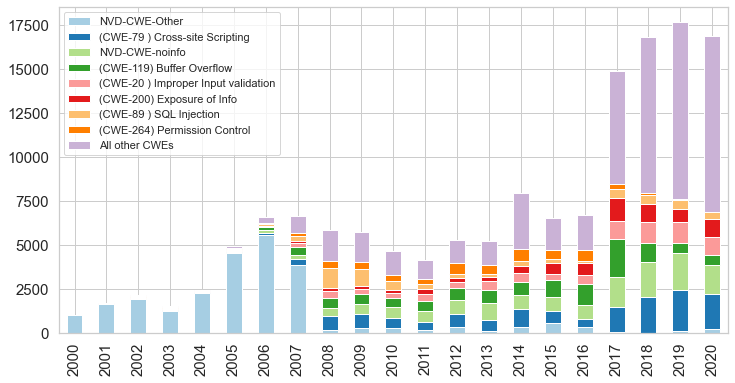

In [66]:
cve_to_cwe_per_year_df[cve_to_cwe_per_year_df.index >= 2000].plot(
    kind='bar', stacked=True,                                                       
    colormap=ListedColormap(sns.color_palette("Paired", 9)), figsize=(12,6));
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

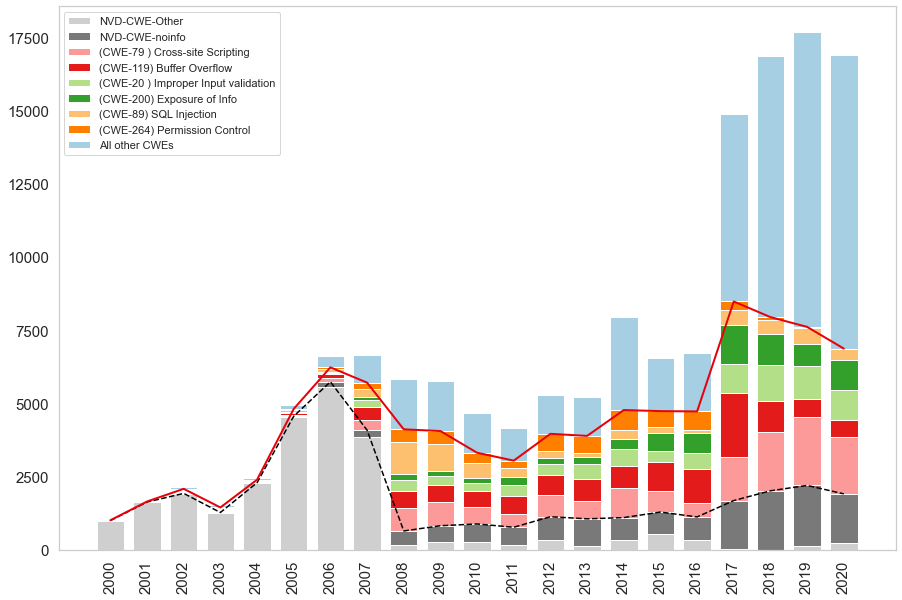

In [67]:
width=0.75
filtered_years = cve_to_cwe_per_year_df[cve_to_cwe_per_year_df.index >= 2000]
fig, ax = plt.subplots(figsize=(15,10))
years = list(filtered_years.index)

nvd_1 = filtered_years['NVD-CWE-Other']
cwe_79 = filtered_years['(CWE-79 ) Cross-site Scripting']
nvd_2 = filtered_years['NVD-CWE-noinfo']
cwe_119 = filtered_years['(CWE-119) Buffer Overflow']
cwe_20 = filtered_years['(CWE-20 ) Improper Input validation']
cwe_200 = filtered_years['(CWE-200) Exposure of Info']
cwe_89 = filtered_years['(CWE-89 ) SQL Injection']
cwe_264 = filtered_years['(CWE-264) Permission Control']
all_other_cwe = filtered_years['All other CWEs']

ax.bar(years, nvd_1, width, label='NVD-CWE-Other', color='#CFCFCF') # '#B4D47B'
ax.bar(years, nvd_2, width, bottom=sum([nvd_1]), label='NVD-CWE-noinfo', color='#797979') # '#F2CF66'
ax.bar(years, cwe_79, width, bottom=sum([nvd_1, nvd_2]), label='(CWE-79 ) Cross-site Scripting', color='#FB9A99')
ax.bar(years, cwe_119, width, bottom=sum([nvd_1, nvd_2, cwe_79]), label='(CWE-119) Buffer Overflow', color='#E31B1B')
ax.bar(years, cwe_20, width, bottom=sum([nvd_1, nvd_2, cwe_79, cwe_119]), label='(CWE-20 ) Improper Input validation', color='#B3DF89')
ax.bar(years, cwe_200, width, bottom=sum([nvd_1, nvd_2, cwe_79, cwe_119, cwe_20]), label='(CWE-200) Exposure of Info', color='#33A02C')
ax.bar(years, cwe_89, width, bottom=sum([nvd_1, nvd_2, cwe_79, cwe_119, cwe_20, cwe_200]), label='(CWE-89) SQL Injection', color='#FCC06F')
ax.bar(years, cwe_264, width, bottom=sum([nvd_1, nvd_2, cwe_79, cwe_119, cwe_20, cwe_200, cwe_89]), label='(CWE-264) Permission Control', color='#FF7F01')
ax.bar(years, all_other_cwe, width, bottom=sum([nvd_1, nvd_2, cwe_79, cwe_119, cwe_20, cwe_200, cwe_89, cwe_264]), label='All other CWEs', color='#A6CFE3')

ax.plot(years, NVD_CWE_Other_only, color='#000000', linestyle='--')
ax.plot(years, majro_cwe_each_year, color='#E8000B', linewidth=2)
ax.legend()
plt.xticks(years,rotation=90);
plt.grid(False)
# plt.box(on=None)

In [68]:
# #############
# Count CWEs causing CVE in 2017 and after only
# #############

cwe_count = {}
for val in cve_clean_result:
    year = val['published_date'].split('-')[0]
    if int(year) < 2017:
        continue
    for cwe in val['related_cwe_list']:
        cwe_c = cwe_count.get(cwe, 0)
        cwe_c += 1
        cwe_count[cwe] = cwe_c

In [69]:
data = {'cwe_id':[], 'count':[]}
for key, value in cwe_count.items():
    data['cwe_id'].append(f'{key}')
    data['count'].append(value)
    
cwe_count_df = pd.DataFrame(data)
cwe_count_df.sort_values(by=['count'], ascending=False, inplace=True)
cwe_count_df.reset_index(drop=True, inplace=True)
cwe_count_filtered_gt_n = cwe_count_df[cwe_count_df['count'] >= 200]

In [70]:
cwe_count_df

,cwe_id,count
0,CWE-79,7769
1,NVD-CWE-noinfo,7417
2,CWE-119,4416
3,CWE-20,4403
4,CWE-200,4132
...,...,...
212,CWE-299,1
213,CWE-216,1
214,CWE-371,1
215,CWE-342,1


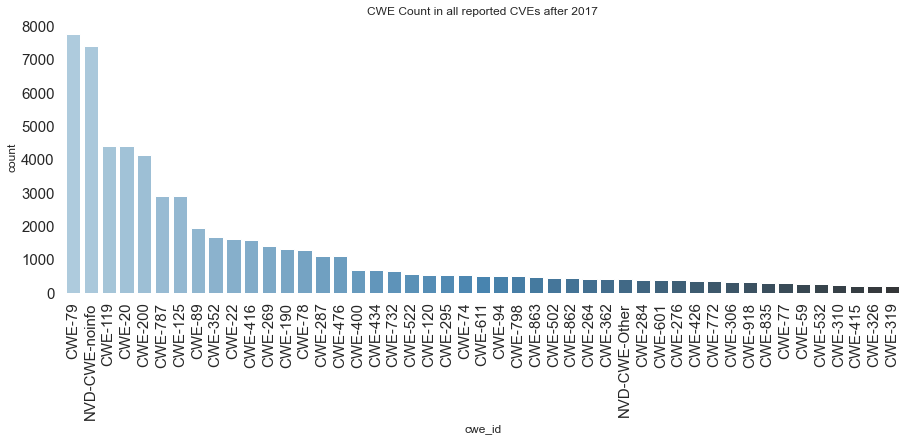

In [71]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="cwe_id", y="count", palette="Blues_d", data=cwe_count_filtered_gt_n, ci=None);
plt.title('CWE Count in all reported CVEs after 2017')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

In [72]:
less_than_n_cwe = cwe_count_df[cwe_count_df['count'] < 2000]['count'].sum()

In [73]:
less_than_n_cwe

32385

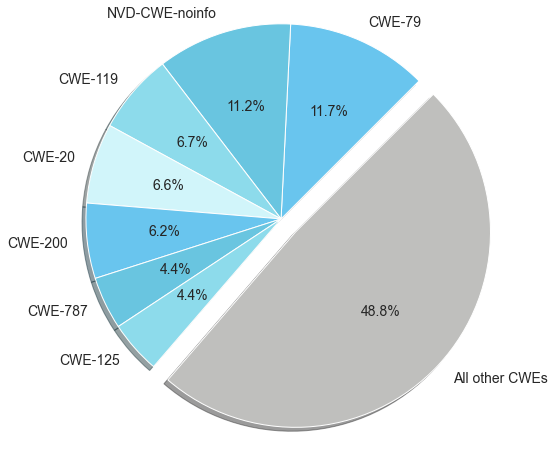

In [74]:
labels = list(cwe_count_df[cwe_count_df['count'] >= 2000]['cwe_id'])
labels.append('All other CWEs')
sizes = list(cwe_count_df[cwe_count_df['count'] >= 2000]['count'])
sizes.append(less_than_n_cwe)
explode = (0,0,0,0,0,0,0, 0.1)
pie_chart_color_list=["#53AAC0", "#53AACC", "#69C5E0", "#8DDBEB", "#D1F5FA"]
pie_chart_color_list=["#69C5EE", "#69C5E0", "#8DDBEB", "#D1F5FA","#69C5EE", "#69C5E0", "#8DDBEB",  '#BFBFBD']
# pie_chart_color_list=["#53AACC",'#ffcc99' ,'#66b3ff','#99ff99','#ff9999']

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45, colors=pie_chart_color_list, textprops={'fontsize': 14})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [86]:
sum(sizes)

1641375

In [75]:
# #############
# Companies reporting CVEs
# #############
company_counter = {}
product_counter = {}
company_product_counter = {}
for val in cve_clean_result:
    impacted_cpe_list = val['impacted_config']
    for val2 in impacted_cpe_list:
        company = val2.split(':')[3]
        product = val2.split(':')[4]
        company_product = f'{company}:{product}'

        c = company_counter.get(company, 0)
        c += 1
        company_counter[company] = c
        
        c = product_counter.get(product, 0)
        c += 1
        product_counter[product] = c
        
        c = company_product_counter.get(company_product, 0)
        c += 1
        company_product_counter[company_product] = c

In [76]:
data = {'company':[], 'count':[]}
for key, value in company_counter.items():
    data['company'].append(f'{key}')
    data['count'].append(value)
    
company_count_df = pd.DataFrame(data)
company_count_df.sort_values(by=['count'], ascending=False, inplace=True)
company_count_df.reset_index(drop=True, inplace=True)
company_count_filtered_gt_n = company_count_df[company_count_df['count'] >= 5000]

In [77]:
print('Total impacted products: ', sum(company_count_df['count']))

Total impacted products:  1641375


In [78]:
company_count_filtered_gt_n

,company,count
0,cisco,127523
1,linux,92719
2,apple,84148
3,mozilla,84066
4,microsoft,83039
5,adobe,66116
6,ibm,59051
7,sun,59027
8,google,55781
9,oracle,52539


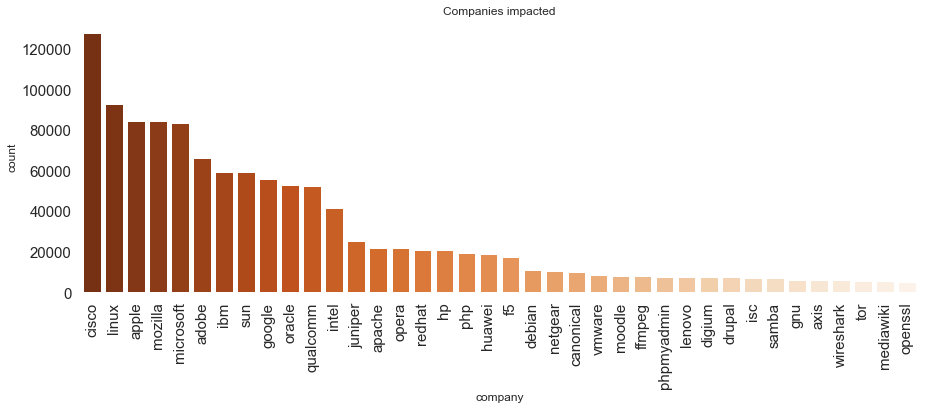

In [79]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="company", y="count", palette="Oranges_r", data=company_count_filtered_gt_n, ci=None);
# plt.yscale('log')
plt.title('Companies impacted')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

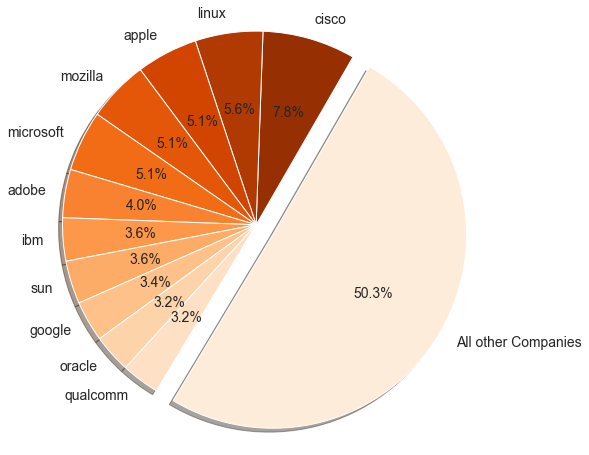

In [80]:
less_than_n_cwe = company_count_df[company_count_df['count'] < 50000]['count'].sum()
labels = list(company_count_df[company_count_df['count'] >= 50000]['company'])
labels.append('All other Companies')
sizes = list(company_count_df[company_count_df['count'] >= 50000]['count'])
sizes.append(less_than_n_cwe)
explode = (0,0,0,0,0,0,0,0,0,0,0, 0.1)
# pie_chart_color_list=["#53AAC0", "#53AACC", "#69C5E0", "#8DDBEB", "#D1F5FA"]
# pie_chart_color_list=["#69C5EE", "#69C5E0", "#8DDBEB", "#D1F5FA","#69C5EE", "#69C5E0", "#8DDBEB",  '#BFBFBD']
# pie_chart_color_list=["#53AACC",'#ffcc99' ,'#66b3ff','#99ff99','#ff9999']

fig1, ax1 = plt.subplots(figsize=(8,8))
# 
# colors=pie_chart_color_list,

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("Oranges_r", 12),
        shadow=True, startangle=60,  textprops={'fontsize': 14}, explode=explode)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [81]:
data = {'product':[], 'count':[]}
for key, value in product_counter.items():
    data['product'].append(f'{key}')
    data['count'].append(value)
    
product_count_df = pd.DataFrame(data)
product_count_df.sort_values(by=['count'], ascending=False, inplace=True)
product_count_df.reset_index(drop=True, inplace=True)
product_count_filtered_gt_n = product_count_df[product_count_df['count'] >= 5000]

In [82]:
product_count_filtered_gt_n

,product,count
0,linux_kernel,92481
1,ios,54871
2,chrome,38318
3,firefox,34344
4,jre,28192
5,jdk,23900
6,seamonkey,22808
7,flash_player,21707
8,opera_browser,20975
9,junos,19218


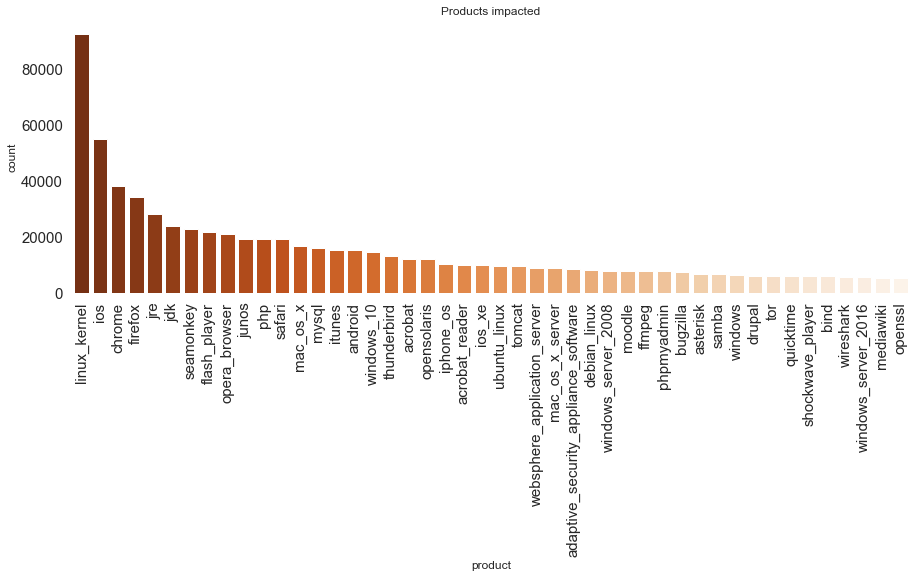

In [83]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="product", y="count", palette="Oranges_r", data=product_count_filtered_gt_n, ci=None);
# plt.yscale('log')
plt.title('Products impacted')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

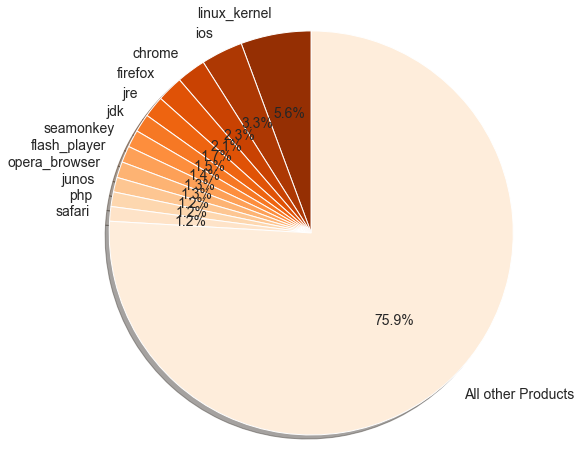

In [84]:
less_than_n_cwe = product_count_df[product_count_df['count'] < 17000]['count'].sum()
labels = list(product_count_df[product_count_df['count'] >= 17000]['product'])
labels.append('All other Products')
sizes = list(product_count_df[product_count_df['count'] >= 17000]['count'])
sizes.append(less_than_n_cwe)
# explode = (0,0,0,0,0,0,0,0,0,0,0, 0.1)
# pie_chart_color_list=["#53AAC0", "#53AACC", "#69C5E0", "#8DDBEB", "#D1F5FA"]
# pie_chart_color_list=["#69C5EE", "#69C5E0", "#8DDBEB", "#D1F5FA","#69C5EE", "#69C5E0", "#8DDBEB",  '#BFBFBD']
# pie_chart_color_list=["#53AACC",'#ffcc99' ,'#66b3ff','#99ff99','#ff9999']

fig1, ax1 = plt.subplots(figsize=(8,8))
# 
# colors=pie_chart_color_list,

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("Oranges_r",13),
        shadow=True, startangle=90,  textprops={'fontsize': 14}) # explode=explode
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()